In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import math
%matplotlib inline

In [2]:
train_dataset = pd.read_csv('./dataset/train.csv').values
test_dataset = pd.read_csv('./dataset/test.csv').values

In [3]:
X_data = []

for d in train_dataset:
  X_data.append(d[0])

for d in test_dataset:
  X_data.append(d[0])

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer

t = Tokenizer()
t.fit_on_texts(X_data)

In [5]:
vocab_size = len(t.word_index) + 1

In [6]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

sequences_data = t.texts_to_sequences(X_data)

In [7]:
tweet_num = 30

In [8]:
embeddings_index = dict()
f = open('./dataset/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [9]:
embedding_matrix = np.zeros((vocab_size, 100))

for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [10]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix],
                            input_length = tweet_num, trainable=False)

In [11]:
X_train = []
y_train = []

for d in train_dataset:
  X_train.append(d[0])
  y_train.append(d[1])

sequences_train = t.texts_to_sequences(X_train)

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = tweet_num
padded_X_train = pad_sequences(sequences_train, padding='post', maxlen=maxlen)

labels_train = to_categorical(np.asarray(y_train))

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(padded_X_train, labels_train, test_size = 0.2, random_state = 0)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, GRU, BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from keras import regularizers

Using TensorFlow backend.


In [15]:
best_model_filepath = './best_model.h5'
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')
saveBestModel = tf.keras.callbacks.ModelCheckpoint(best_model_filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

In [16]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(GRU(256, dropout = 0.2, recurrent_dropout = 0.5, return_sequences = True))
model.add(GRU(128, dropout = 0.2, recurrent_dropout = 0.5, return_sequences = True))
model.add(GRU(64, dropout = 0.2, recurrent_dropout = 0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1576900   
_________________________________________________________________
dropout (Dropout)            (None, 30, 100)           0         
_________________________________________________________________
gru (GRU)                    (None, 30, 256)           274944    
_________________________________________________________________
gru_1 (GRU)                  (None, 30, 128)           148224    
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0

In [18]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

In [20]:
hist = model.fit(X_train, y_train, epochs=1000, batch_size=128,
                 validation_data=(X_validation, y_validation), callbacks=[earlyStopping, saveBestModel])

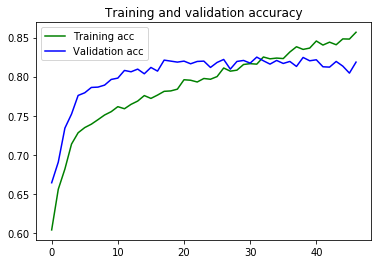

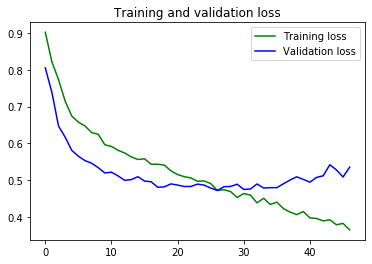

In [28]:
acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
from tensorflow.keras.models import load_model

model = load_model('best_model.h5')

In [63]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy:   {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_validation, y_validation, verbose=False)
print("Validation Accuracy: {:.4f}".format(accuracy))

Training Accuracy:   0.8651
Validation Accuracy: 0.8229


In [22]:
X_test = []

for d in test_dataset:
  X_test.append(d[0])

sequences_test = t.texts_to_sequences(X_test)

padded_X_test = pad_sequences(sequences_test, padding='post', maxlen=maxlen)

test = padded_X_test

In [23]:
y_pred = model.predict(test)
y_pred_array = np.zeros(test.shape[0])

for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i])
    y_pred_array[i] = label_predict

y_pred_array = y_pred_array.astype(int)

In [24]:
import csv

with open('output.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Id', 'Category'])
    
for i in range(0, y_pred.shape[0]):
    row = []
    row.append(i)
    row.append(y_pred_array[i])
    with open('output.csv', 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(row)